# Stratification vs Random

We compare the precidence predictions for the following prediction strategies in EpiOS:
- Random
- Age stratification
- Region stratification

Imports

In [1]:
import epios

from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import time

In [2]:
path = '.'
# This assumes the python venv is installed under EpiOS folder
demo_data = pd.read_csv(f'{path}/simulation_outputs/demographics.csv')
time_data = pd.read_csv(f'{path}/simulation_outputs/inf_status_history.csv')

In [3]:
def predict_base(post_process: epios.PostProcess, sample_size: int,
                 time_sample: List[int], comparison: bool,
                 sample_strategy: str) -> Tuple[np.array, ...]:
    """Uses the `Base` method from `epios.PostProcess` to predict prevalence
    from a sample.

    Returns
    -------
    Tuple[np.array, ...]
         Returns the times, true and predicted incidence rates in a tuple to be
         used for further analysis
    """
    # Make prediction
    result, diff = post_process.predict.Base(sample_size=sample_size,
                                             time_sample=time_sample,
                                             comparison=comparison,
                                             gen_plot=False,
                                             sample_strategy=sample_strategy)

    # Find population size and get true data
    pop_size = len(post_process.demo_data)
    times, base_prediction = result[0], np.array(result[1]) * pop_size
    true = diff + base_prediction
    base_prediction_age_groups = post_process.predict.result_ages

    return times, true, base_prediction, base_prediction_age_groups

In [4]:
def predict_age(post_process: epios.PostProcess, sample_size: int,
                 time_sample: List[int], comparison: bool,
                 sample_strategy: str) -> Tuple[np.array, ...]:
    """Uses the `Age` method from `epios.PostProcess` to predict prevalence
    from a sample.

    Returns
    -------
    Tuple[np.array, ...]
         Returns the times, true and predicted incidence rates in a tuple to be
         used for further analysis
    """
    # Make prediction
    result, diff = post_process.predict.Age(sample_size=sample_size,
                                             time_sample=time_sample,
                                             comparison=comparison,
                                             gen_plot=False,
                                             sample_strategy=sample_strategy)

    # Find population size and get true data
    pop_size = len(post_process.demo_data)
    times, age_prediction = result[0], np.array(result[1]) * pop_size
    true = diff + age_prediction
    age_prediction_age_groups = post_process.predict.result_ages

    return times, true, age_prediction, age_prediction_age_groups

## Finding samples using Random, Age, and Region methods

In [5]:
def rand(post_process: epios.PostProcess, sample_size: int,
                  time_sample: List[int], comparison: bool) -> Tuple[np.array, ...]:
    """This returns predictions from the Random sampling strategies,
    without plotting. These will be averaged over multiple runs

    Returns
    -------
    Tuple[np.array, ...]
        Times array, true results, predictions with Random strategy
    """
    # Do prediction and comparison with Random sampling strategy - this samples
    # different people every time step
    random = predict_base(post_process=post_process,
                               sample_size=sample_size,
                               time_sample=time_sample,
                               comparison=comparison,
                               sample_strategy='Random')
    times, true, base_pred, base_pred_age_groups = random

    return times, true, base_pred, base_pred_age_groups

In [6]:
def age(post_process: epios.PostProcess, sample_size: int,
                  time_sample: List[int], comparison: bool) -> Tuple[np.array, ...]:
    """This returns predictions from the age stratification, without plotting.
    These will be averaged over multiple runs

    Returns
    -------
    np.array
        Predictions with Random strategy
    """
    # Do prediction and comparison with Random sampling strategy - this samples
    # different people every time step
    age_strat = predict_age(post_process=post_process,
                               sample_size=sample_size,
                               time_sample=time_sample,
                               comparison=comparison,
                               sample_strategy='Random')
    times, true, age_pred, age_pred_age_groups = age_strat

    return times, true, age_pred, age_pred_age_groups

## Calculating the true number of infections per age group

In [7]:
def count_people_by_age_group(demo_data, time_data, time_sample, num_age_group=17, age_group_width=5):
    """
    Count the true number of people within each age group that are infected.

    Parameters
    ----------
    demo_data: pandas.DataFrame
        Demographic data of the population
    time_data: pandas.DataFrame
        The infection data of the population at different time points
    time_sample: list
        A list of time points to sample the population
    num_age_group: int
        Number of age groups within the population
    age_group_width: int
        Number of ages within an age group

    Returns
    -------
    list[list, ...]
        A list containing a list of infection totals for each time point. Here,
        each list represents an age group
    """
    df = demo_data
    inf_history = time_data
    total_count_age_groups = []
    total_by_age = []

    # Group data by age groups
    for i in range(num_age_group):
        min_age = i * age_group_width
        max_age = min_age + age_group_width
        if i == num_age_group - 1:
            max_age = float('inf')  # Last group includes age >= some threshold

        age_group_data = df[df['age'].between(min_age, max_age-0.01)]

        selected_columns = [col for col in inf_history.columns if str(col) in age_group_data['id'].astype(str).values]
        selected_data = inf_history[selected_columns]

        selected_data = selected_data.iloc[time_sample]

        people_by_age = len(selected_data.columns)
        count_by_age_group = selected_data.apply(lambda row: row.isin(range(3, 9)).sum(), axis=1).tolist()
        total_count_age_groups.append(count_by_age_group)
        total_by_age.append(people_by_age)

    return total_count_age_groups, total_by_age

In [8]:
time_sample = [num for num in range(366)]
groups, total_by_age_groups = count_people_by_age_group(demo_data, time_data, time_sample)

In [9]:
post_process = epios.PostProcess(demo_data=demo_data, time_data=time_data)

# Initialise the random_predictions and RMSEs
random_predictions = []
random_rmses = []

### Here will we average the predictions, for both the total prediction and the stratified predictions

In [ ]:
num_iters = 10
result = [[0] * 366 for _ in range(17)]
start_time = time.time()
for j in range(num_iters):
    predictions = rand(post_process=post_process,
                       sample_size=100,
                       time_sample=time_sample,
                       comparison=True)
    times, true, base_pred, base_pred_age_groups = predictions
    random_predictions.append(base_pred)
    age_pred, age_pred_age_groups = age(post_process=post_process,
                       sample_size=100,
                       time_sample=time_sample,
                       comparison=True)[2, 3]

    print(f"Iteration {j}")
    result = [[base_pred_age_groups[i][j] + result[i][j] for j in range(len(base_pred_age_groups[i]))] for i in range(len(base_pred_age_groups))]
result = [[(element / num_iters) for element in sublist] for sublist in result]
    
end_time = time.time()
run_time = end_time - start_time
print(f"Time taken for calculation to run for {num_iters} iterations: {round(run_time, 2)} seconds")

### Saving to .csv files

In [ ]:
true_total = pd.DataFrame(true)
random_df_total = pd.DataFrame(base_pred)
random_df_by_age = pd.DataFrame(result)
true_total.to_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/true_total_infections.csv')
random_df_by_age.to_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/averaged_predictions_by_age.csv')
random_df_total.to_csv('C:/Users/evana/EpiOS/stratified_random/random_strategy/averaged_predictions.csv')

## Plots

Here we are plotting the true infection total against the prediction

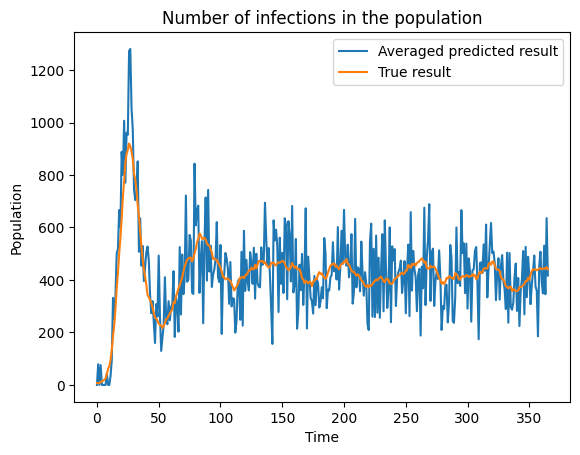

In [43]:
plt.figure()
#plt.plot(time_sample, [element * total_by_age_groups[16] for element in pred_age_groups[16]], label='Predicted result')
plt.plot(time_sample, [element * total_by_age_groups[0] for element in result[0]], label='Averaged predicted result')
#plt.plot(time_sample, pred_random, label='Predicted result')
#plt.plot(time_sample, true, label='True result')
plt.plot(time_sample, groups[0], label='True result')
#plt.plot(time_sample, np.abs(diff), label='Absolute difference')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Number of infections in the population')
plt.show()

Here we will plot the error of each prediction method, showing how they perform at predicting the total number of infections for the total population, age groups, and regions. We will also compare how the accuracy scales with the length of time to run the code.

In [14]:
data = [["Random", "", 91],
        ["Age", round(run_time, 2), np.mean(random_rmse_array)], 
        ["Region", "", 94]]

col_names = ["Strategy", "Time to run (seconds)", "Average RMSE"]

print(tabulate(data, headers=col_names))

Strategy    Time to run (seconds)      Average RMSE
----------  -----------------------  --------------
Random      Suns                              91
Age         300.97                          1394.66
Region      Spurs                             94
